# EASY-ML Hands On Session 21 - 22 July 2025 : Flood detection with satellite images

## Introduction and objectives of the exercise

Severe flooding hit Nairobi and the surrounding area from April to May 2024, taking a heavy human and material toll, with at least 267 deaths.

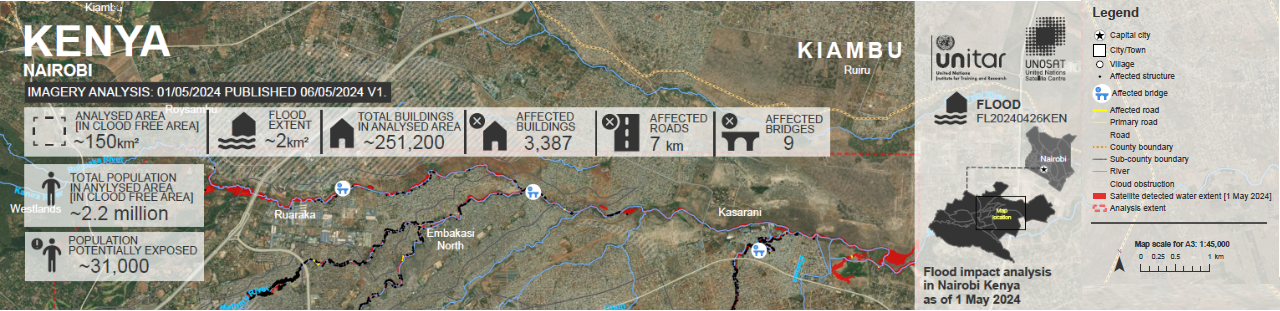
Report source: https://unosat.org/products/3834

Being able to rapidly produce maps of flooded areas in near-real time from satellite imagery is useful for coordinating rescue operations and managing the post-crisis phase.

In this exercise, you will use 10m resolution images from the Sentinel-2 satellite to train machine learning models to map flooded areas.

By the end of the two sessions, you should be able to produce a map of the flooded areas, explain your approach (including your choice of data and models) and critically assess the model's performance. The objective is to analyze where the model predicts flooding and, as much as possible, understand why it may make errors in specific areas.

The Sentinel-2 satellites correspond to a constellation of two satellites (Sentinel- 2A and Sentinel-2B) launched in 2015 and 2017 by the European Space Agency (ESA) as part of the Copernicus program. This program was developed with the aim of providing free, open-source, high-resolution (10 - 20 m) images of land surfaces across the globe with a high temporal revisit time (10 days at the equator with one satellite and five days with two satellites at mid-latitudes). Satellites capture radiation from the visible to the near- and mid-infrared range, with spatial resolutions ranging from 10 m to 60 m in 13 spectral bands.

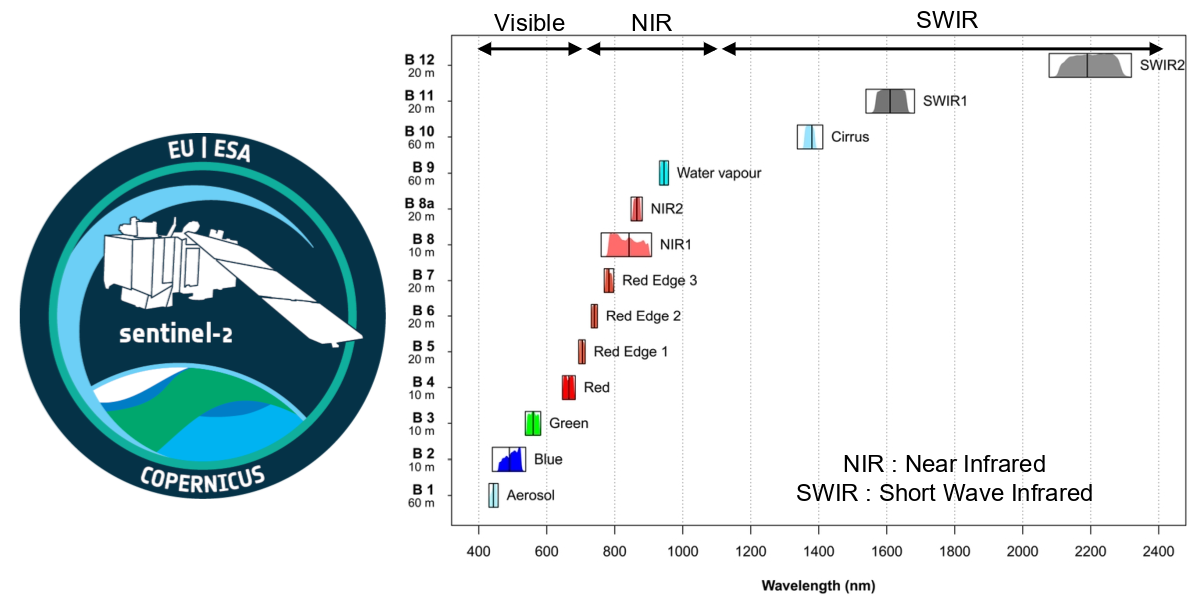

Images can be downloaded from the Copernicus website: https://browser.dataspace.copernicus.eu/

You can also view images from the site in anonymous mode and compare the characteristics of the different bands.

The images provided to users by the Copernicus browser are 110 x 100 km tiles with different levels of pre-processing:
* Level-1C: images measuring reflectance at the top of the atmosphere (TOA), orthorectified and in metric units (UTM);
* Level-2A: surface reflectance images (after atmospheric correction) at the bottom of the atmosphere (BOA), orthorectified and in metric units (UTM).

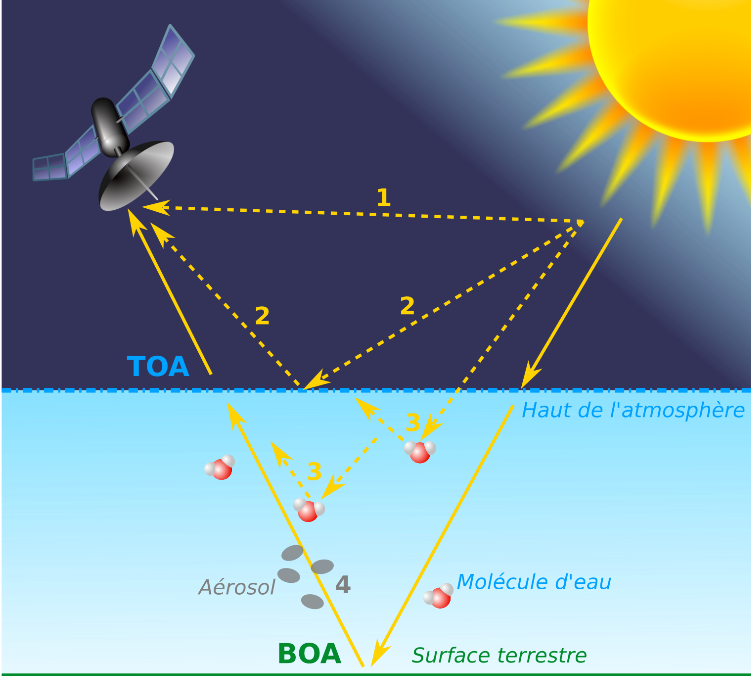

## Data at your disposal for the exercise
---------------------------------------------------------------------------
Two images at L2A level (i.e. after atmospheric correction) with low cloud

cover were selected:
* image of April 07, 2024: before the strongest flood events
* image from April 22, 2024: after major flood events

The raw images (110 x 110 km) are available in the folder `Raw_images`.

---------------------------------------------------------------------------
Part of the preprocessing is already done to reduce the processing time in this exercise: the images were cropped to focus on the study area and only the most relevant bands were kept, i.e. B02, B03, B04, B05, B06, B07, B08, B8A, B11, B12. They are stored in the folder `Input_data`. You can view the reflectances associated with different bands here : https://bitly.cx/BwceY (please be patient, it may take a while).
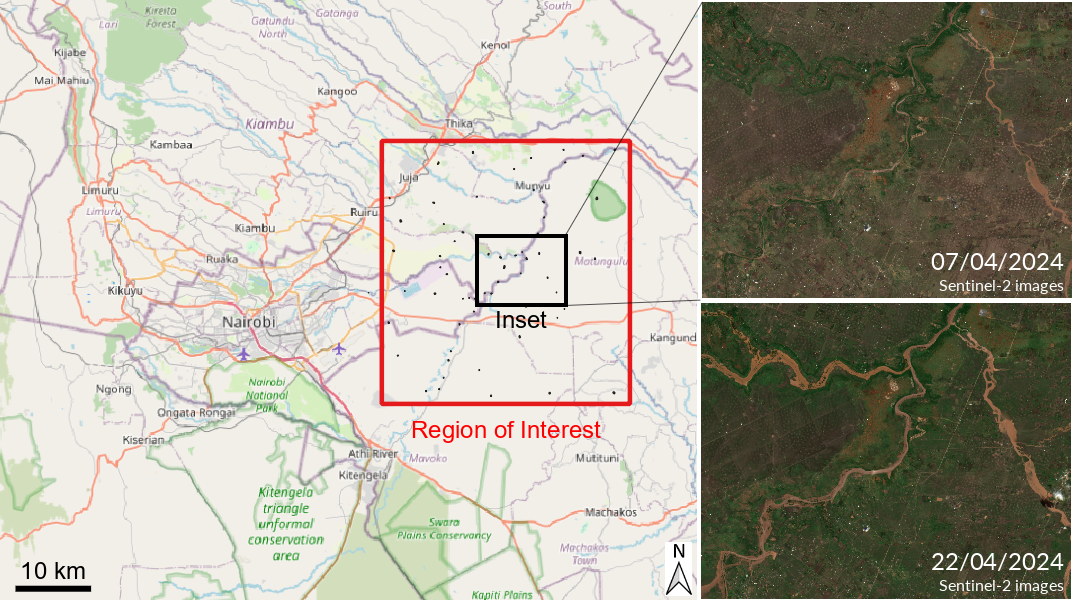

---------------------------------------------------------------------------
Then there are shapefiles (viewable in QGIS) stored in the folder `Shapefile`, which correspond to polygons of:
* our region of interest (`ROI_Nairobi_flood.shp`), which defines the boundaries of the study area
* portions of the image used to build the training and test datasets (`training_data_Nairobi_flood.shp` and `testing_data_Nairobi_flood.shp`)
* the UNOSAT map of flooded areas on May 1st 2024 `PL_20240501_FloodExtent_Nairobi_Kiambu.shp`. This map cannot be used directly as ground truth, as between the date of our image (April 22nd) and May 1st, flooding progressed in some sections of the drainage network, while in other sections it receded.

---------------------------------------------------------------------------
Finally, there is some additional data in the `Additional_files` folder which, depending on your choices, you may find useful; these will be presented later in this notebook.


---------------------------------------------------------------------------
# Beginning of the script: preparation of google drive
---------------------------------------------------------------------------

This notebook shows you **how to perform the first pre-processing steps**. All the steps are pre-prepared, so you don't have to waste any time - **all you have to do is run the cells** and **change folder paths**.

**The aim** of showing you how to perform all these steps is to demonstrate the importance of data preparation and **teach you how to carry out these steps**. If your data is poorly prepared, your model will make poor predictions.

Satellite images require a lot of pre-processing. If you want to be able to run a machine/deep learning model on satellite images you need to:
* correct for atmospheric distortions --> this step is done by the data provider (Copernicus). You need to make sure you have images at L2A level.
* for simple models, you need to have all input data at the same spatial resolution. For this exercise, we want a resolution of 10 m (i.e. a pixel is 10 x 10 m).
* normalize your data


Installation of rasterio library

In [9]:
pip install rasterio


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

-f option requires 1 argument


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---------------------------------------------------------------------------
# Import package
---------------------------------------------------------------------------

In [ ]:
import numpy as np # Import the numpy library for numerical operations
import rasterio as rio # Import the rasterio library for raster manipulation
import matplotlib.pyplot as plt # Import matplotlib for plotting images
import shapefile
import shapely.geometry as spg
from shapely.geometry import shape as shapely_shape
from rasterio.transform import from_origin
from rasterio.features import geometry_mask
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from rasterio.features import rasterize
from shapely.ops import unary_union
import os

---------------------------------------------------------------------------
# Download data and preprocess
---------------------------------------------------------------------------

### Step 1: Resampling
The first step in pre-processing is to download the images and resample to 10m the bands that were originally at 20m. The `resampled_raster` function, in the cell below, takes care of this step. In the next cell **you only need to change the folder access name if necessary** and **run the cells of this section**.

After this step, the **images will be stored as a stack**, i.e. a 3-dimensional tensor: (nb bands, image height, image width).

The resampled data are now stored in the folder Ìnput_data_preprocess`.



In [ ]:
def resampled_raster(src_path, dst_path, resolution=10):
    """
    Resample a raster from 20m resolution to a target resolution (default is 10m).

    This function is designed for Sentinel-2 bands that are originally at 20m resolution
    (e.g., B05, B06, B07, B8A, B11, B12), and resamples them to match the 10m resolution bands.

    Parameters:
        src_path (str): Path to the input raster file (20m resolution).
        dst_path (str): Path to save the resampled output raster (10m resolution).
        resolution (int): Target spatial resolution (default: 10 meters).

    Returns:
        data (ndarray): Resampled image data as a NumPy array.
    """

    # Open the source raster file for reading
    with rio.open(src_path) as src:
        # Calculate the upscale factor (e.g., 20 / 10 = 2)
        upscale_factor = int(src.res[0] / resolution)

        # Resample the image data using bilinear interpolation
        # The new shape is computed by multiplying original height and width by the upscale factor
        data = src.read(
            out_shape=(
                src.count,  # number of bands
                int(src.height * upscale_factor),  # new height
                int(src.width * upscale_factor)    # new width
            ),
            resampling=rio.enums.Resampling.bilinear  # bilinear resampling method
        )

        # Adjust the spatial transform to reflect the new resolution and dimensions
        transform = src.transform * src.transform.scale(
            (src.width / data.shape[-1]),   # scale factor in X direction
            (src.height / data.shape[-2])   # scale factor in Y direction
        )

        # Copy the original metadata profile and update with new shape and transform
        profile = src.profile
        profile.update({
            'height': data.shape[1],     # updated height
            'width': data.shape[2],      # updated width
            'transform': transform       # updated geotransform
        })

        # Write the resampled data to the output file
        with rio.open(dst_path, 'w', **profile) as dst:
            dst.write(data)

    # Print confirmation message
    print(src_path + " ---> resampled")

    # Return the resampled data as a NumPy array
    return data

In [ ]:
# DEFINITION OF FILES PATH

dataset_folder = "/content/drive/MyDrive/EASY-ML_Flood_Detection/Input_data"
process_folder = "/content/drive/MyDrive/EASY-ML_Flood_Detection/Input_data_process"

# Check if folder exists
if not os.path.exists(dataset_folder):
    raise FileNotFoundError(f"Folder '{dataset_folder}' not found in Google Drive.")
os.makedirs(process_folder, exist_ok=True)

file_paths = [dataset_folder + "/ROI_B02_10m.jp2",
              dataset_folder + "/ROI_B03_10m.jp2",
              dataset_folder + "/ROI_B04_10m.jp2",
              dataset_folder + "/ROI_B05_20m.jp2",
              dataset_folder + "/ROI_B06_20m.jp2",
              dataset_folder + "/ROI_B07_20m.jp2",
              dataset_folder + "/ROI_B08_10m.jp2",
              dataset_folder + "/ROI_B8A_20m.jp2",
              dataset_folder + "/ROI_B11_20m.jp2",
              dataset_folder + "/ROI_B12_20m.jp2"]

In [ ]:
# LOAD DATA AND RESAMPLE 20M RESOLUTION BANDS TO 10M RESOLUTION
stack = []
for band in file_paths :
    # define path
    input_path = f"{dataset_folder}/ROI_{band[-11:]}"
    output_path = f"{process_folder}/ROI_{band[-11:-8]}_10m.jp2"

    print(input_path)
    print(output_path)
    # Read raster
    with rio.open(band) as src:
        roi_profile = src.meta.copy()
        roi_array = src.read()

    # Resample 20 m to 10 m
    if roi_profile['transform'][0] != 10 :
        roi_array = resampled_raster(input_path, dst_path=output_path)
        roi_array = roi_array[:,1:-1,:]

    print(roi_array.shape)

    stack.append(roi_array[0,1:-1,:])

# All the bands are stack in a 3D array
stacked = np.array(stack)
print("stacked shape:", stacked.shape)


"""
For example, to select band B04, you need to know its position in the stack,
in this case the 3rd layer. So we retrieve only the band's values, as follows:
"""
B04 = stacked[2,:,:]  # 2 instead of 3 because we start counting at 0
print("B04 shape:", B04.shape)

/content/drive/MyDrive/EASY-ML_Flood_Detection/Input_data/ROI_B02_10m.jp2
/content/drive/MyDrive/EASY-ML_Flood_Detection/Input_data_process/ROI_B02_10m.jp2
(1, 3632, 3426)
/content/drive/MyDrive/EASY-ML_Flood_Detection/Input_data/ROI_B03_10m.jp2
/content/drive/MyDrive/EASY-ML_Flood_Detection/Input_data_process/ROI_B03_10m.jp2
(1, 3632, 3426)
/content/drive/MyDrive/EASY-ML_Flood_Detection/Input_data/ROI_B04_10m.jp2
/content/drive/MyDrive/EASY-ML_Flood_Detection/Input_data_process/ROI_B04_10m.jp2
(1, 3632, 3426)
/content/drive/MyDrive/EASY-ML_Flood_Detection/Input_data/ROI_B05_20m.jp2
/content/drive/MyDrive/EASY-ML_Flood_Detection/Input_data_process/ROI_B05_10m.jp2


CPLE_AppDefinedError: Deleting /content/drive/MyDrive/EASY-ML_Flood_Detection/Input_data_process/ROI_B05_10m.jp2 failed: Operation not permitted

### Step 2: Feature engineering

Now we move on to the **feature engineering** stage (manual extraction of features relevant to the task), as we will be using machine learning models. Classically, for flood detection, this involves **calculating indices from the various bands**.

In this section, **you need to choose the indices you want to calculate**. I'll give you an example of how to calculate the best-known index (`NDVI`) in function `calc_indices`. It's up to you to **complete the `calc_indices` function with the new indices you wish to use**. I explain what `NDVI` is and where to find other indices just below.

The best-known indices are NDVI (Normalized Difference Vegetation Index) and NDWI (Normalized Difference Water Index).

\begin{align}
    NDVI = \frac{B08 - B04}{B08 + B04}
\end{align}
\begin{align}
\end{align}
\begin{align}
    NDMI = \frac{B03 - B08}{B03 + B08}
\end{align}

You can also try some other less frequently used indices:
* https://www.mdpi.com/2072-4292/17/5/770
* https://www.sciencedirect.com/science/article/pii/S0098300424002255?via%3Dihub


In [ ]:
# FEATURE ENGINEERING
def calc_indices(stack):
    """
    Calculation of NDVI and MDWI indices
    """
    B2, B3, B4, B5, B6, B7, B8, B8A, B11, B12 = stack # Be careful to have this order in your stack
    ndvi = (B8 - B4) / (B8 + B4 + 1e-6) # Add small value to avoid division by zero

    ### /!\ Compute others indices here /!\ ###
    return np.stack([*stack, ndvi])

stacked_indices = calc_indices(stacked)

---------------------------------------------------------------------------
Preparation of training data
---------------------------------------------------------------------------

### Step 3: Normalization
Now that we have finished pre-processing the satellite images, we need **to transform this images them into a training dataset**.

To do this, we need to **normalize the data**, as is done in all machine learning models. This is already done in the next cell with the `normalize_stack` function. **Just run the next cell**.


In order to have the same distribution between the train dataset, test dataset and the entire area (for make the prediction map), we applied the normalization into the stack of bands. Bands are normalized one by one.



In [ ]:
def normalize_stack(stack):
    """
    Normalize each band/layer of a 3D stack independently to [0, 1] range.

    Parameters:
        stack (ndarray): A 3D NumPy array of shape (bands, height, width).

    Returns:
        normalize_stack (ndarray): A 3D array with each band normalized.
    """

    # Create an empty array with the same shape as the input to store normalized data
    normalize_stack = np.zeros_like(stack)

    # Loop through each band (assumed along the first dimension)
    for i in range(stack.shape[0]):
        data = stack[i, :, :]  # Extract the i-th band (2D array)

        min_data = np.min(data)  # Minimum value in the current band
        max_data = np.max(data)  # Maximum value in the current band

        # Normalize the band to [0, 1] using min-max scaling
        data = (data - min_data) / (max_data - min_data)

        # Store the normalized band in the output array
        normalize_stack[i, :, :] = data

    # Return the fully normalized stack
    return normalize_stack

# Apply data normalization
stacked_normalized = normalize_stack(stacked_indices)
full_stack = stacked_normalized

### Step 4: Definition of training and testing areas

This step involves defining the zones to be used for training and testing, and the associated labels. This step **has already been carried out** in QGIS, by creating small polygons in the flooded and non-flooded zones. This corresponds to the files (`training_data_Nairobi_flood.shp` and `testing_data_Nairobi_flood.shp`) provided in the `Shapefile` folder. You can view the location of these areas in QGIS by opening the file `Nairobi.qgz`.

### Step 5: Data extraction within training/testing areas

This step is **already fully coded**, so **you need to launch the cells and change the paths if necessary**.

This step consists of selecting all the pixels within the polygons and retrieving the reflectance values associated with each band. **We thus obtain a tabular dataset**, the number of **rows corresponding to the number of samples** and the number of **columns to the number of features** (the different band values in our stack).

These steps are performed by the `load_roi_extraction` functions, which read the polygons and group them together so that we can process them all at once. The `rasterize_shapefile_with_roi` function transforms these polygons (.shp) into a raster image (.tiff) in the same format as our satellite images (stored in `full_stack`). Finally, `extract_pixels_by_mask` recovers the values of all the bands in the stack to create the dataset.



In [ ]:
"""
Functions for extract the pixels value inside small polygones
defined as training area or testing area
"""

def load_roi_geometry(roi_path):
    """
    Load and merge all geometries from a shapefile representing the ROI (Region of Interest).

    Parameters:
        roi_path (str): Path to the ROI shapefile.

    Returns:
        roi_union (shapely.geometry): A single merged geometry (union of all polygons in the shapefile).
    """
    # Read the shapefile using pyshp
    roi_sf = shapefile.Reader(roi_path)

    # Convert each shape in the shapefile to a Shapely polygon
    roi_geoms = [shapely_shape({'type': 'Polygon', 'coordinates': [sh.points]}) for sh in roi_sf.shapes()]

    # Merge all geometries into one (union of all ROIs)
    roi_union = unary_union(roi_geoms)

    return roi_union

def rasterize_shapefile_with_roi(shapefile_path, roi_path, transform, shape, class_field="class", dtype='uint8'):
    """
    Rasterize polygons from a ground-truth shapefile, limited to the region defined in an ROI shapefile.

    Parameters:
        shapefile_path (str): Path to the shapefile containing labeled polygons.
        roi_path (str): Path to the shapefile defining the region of interest (ROI).
        transform (Affine): Affine transform for the output raster.
        shape (tuple): Output raster shape as (height, width).
        class_field (str): Name of the field containing the class labels in the shapefile.
        dtype (str): Data type for the output raster.

    Returns:
        rasterized (ndarray): 2D array where each pixel has the class label from the shapefile.
    """
    # Read the ground truth shapefile
    sf = shapefile.Reader(shapefile_path)
    shapes = sf.shapes()
    records = sf.records()

    # Extract the list of field names (excluding deletion flag)
    fields = [f[0] for f in sf.fields[1:]]
    class_index = fields.index(class_field)  # Get index of class field

    # Load and merge all geometries from the ROI shapefile
    roi_geom = load_roi_geometry(roi_path)

    geometries = []
    for shp, rec in zip(shapes, records):
        # Convert the shape to a Shapely polygon
        geom = shapely_shape({'type': 'Polygon', 'coordinates': [shp.points]})

        # Clip the geometry to the ROI (intersection)
        geom = geom.intersection(roi_geom)

        # Only keep valid, non-empty geometries
        if not geom.is_empty:
            # Pair the clipped geometry with its class label
            geometries.append((geom, rec[class_index]))

    # Rasterize the geometries to a 2D array
    rasterized = rasterize(
        geometries,
        out_shape=shape,
        transform=transform,
        fill=2,             # Fill value for pixels outside any shape (e.g., nodata)
        all_touched=False,  # Only rasterize pixels whose center is within the geometry
        dtype=dtype
    )

    return rasterized

def extract_pixels_by_mask(stacked_indices, ground_truth, target_label=1):
    """
    Extract pixel vectors (per band) from a 3D image stack where the ground truth equals a given label.

    Parameters:
        stacked_indices (ndarray): 3D array of shape (bands, height, width).
        ground_truth (ndarray): 2D label image of shape (height, width).
        target_label (int): The label value to extract (e.g., 1 for "flooded").

    Returns:
        X (ndarray): 2D array of shape (N_pixels, N_bands), pixel features.
        y (ndarray): 1D array of shape (N_pixels,), containing the label for each pixel.
    """
    # Create a boolean mask where the label equals the target value
    mask = ground_truth == target_label  # shape: (height, width)

    # Get image dimensions
    bands, height, width = stacked_indices.shape

    # Count the number of selected pixels
    n_pixels = np.count_nonzero(mask)

    # Initialize an array to store feature vectors (pixels x bands)
    X = np.zeros((n_pixels, bands), dtype=stacked_indices.dtype)

    # Loop over each band and extract the pixel values using the mask
    for b in range(bands):
        band_data = stacked_indices[b]
        X[:, b] = band_data[mask]  # Apply 2D mask to each band

    # Create the label array (all entries = target_label)
    y = np.full((n_pixels,), target_label, dtype=np.uint8)

    return X, y

Here we call the various functions described to create the train dataset and the test dataset. **Remember to modify the paths if necessary**. First, we extract all pixels in the **positive class (flooded areas, associated with label 1)**, then all pixels in the **negative class (non-flooded areas, associated with label 0)**, before grouping them into the variables `X_train`, `y_train`, `X_test`, `y_test`. **Simply run the cells**.

In [ ]:
### EXTRACTION TRAIN AND TEST DATASET


### Define file paths for shapefiles and images

# Folder containing shapefiles (training, testing, ROI)
path_folder = "/content/drive/MyDrive/EASY-ML/EASY-ML_Flood_Detection/Shapefile/"

# Path to training and testing polygon shapefiles
training_path = path_folder + "training_data_Nairobi_flood.shp"
testing_path = path_folder + "testing_data_Nairobi_flood.shp"

# Path to the ROI shapefile
roi_path = path_folder + "ROI_Nairobi_flood.shp"

# Folder containing input Sentinel-2 images
images_folder = "/content/drive/MyDrive/EASY-ML/EASY-ML_Flood_Detection/Input_data/"

# Path to a reference image (used to get shape, transform, CRS)
path_images = images_folder + "ROI_B02_10m.jp2"


### Read the reference image to get spatial information
with rio.open(path_images) as src:
    transform = src.transform   # Affine transform of the image
    crs = src.crs               # Coordinate reference system
    shape = (src.height, src.width)  # Image dimensions (height, width)


### Rasterize shapefiles (convert polygons to raster labels)

# Rasterize the training polygons using the ROI (label map)
GT_train = rasterize_shapefile_with_roi(
    shapefile_path=training_path,
    roi_path=roi_path,
    transform=transform,
    shape=shape,
    class_field="class"       # Name of the class label field in the shapefile
)

# Rasterize the testing polygons using the ROI
GT_test = rasterize_shapefile_with_roi(
    shapefile_path=testing_path,
    roi_path=roi_path,
    transform=transform,
    shape=shape,
    class_field="class"
)


# Extract pixel values and labels for training and testing datasets

# Remove the first and last row caused due to artifacts
GT_train = GT_train[1:-1, :]

# Extract positive (label = 1) and negative (label = 0) samples
X_train_pos, y_train_pos = extract_pixels_by_mask(full_stack, GT_train, target_label=1)
X_train_neg, y_train_neg = extract_pixels_by_mask(full_stack, GT_train, target_label=0)

# Combine positive and negative samples for training
X_train = np.vstack((X_train_pos, X_train_neg))
y_train = np.hstack((y_train_pos, y_train_neg))

# Do the same for the test data
GT_test = GT_test[1:-1, :]
X_test_pos, y_test_pos = extract_pixels_by_mask(full_stack, GT_test, target_label=1)
X_test_neg, y_test_neg = extract_pixels_by_mask(full_stack, GT_test, target_label=0)
X_test = np.vstack((X_test_pos, X_test_neg))
y_test = np.hstack((y_test_pos, y_test_neg))


### Shuffle training and testing sets to avoid label order bias
X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)

In [ ]:
### EXPLORATION OF THE DATASET

# Dimensions: (number of samples, number of features)
print(X_train.shape)
print(X_test.shape)

# Number of positive sample (flooded area)
pos_indices = np.where(y_train == 1)[0]
n_pos = len(pos_indices)
print(n_pos)

If the dataset doesn't suit you, you can modify the shapefile from within QGIS, adding or deleting polygons, then load it back onto the drive and restart dataset creation.

---------------------------------------------------------------------------
Training and evaluation
---------------------------------------------------------------------------
**All the pre-processing has been done and the dataset built, it's now up to you to carry out this step.**

To quickly generate a map of flooded areas, try testing machine learning models such as `RandomForest` and `SVM` first. If you have enough time, you can then test more complex models such as `1DCNN` (or any other models of your choice that uses tabular data).

**Choose which bands to keep (in the following section, I provide help on how to select data.)** and then **train the model** with either `RandomForestClassifier` or `LinearSVC` proposed by `sklearn`, **and evaluate the performance** on the test dataset.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

In [ ]:
# Your code here: build, train and evaluate model(s)

# Try out different input data (optical data, infrared data, combined data, etc.) to find the data that gives the best performance.

# Try out different models to find the model that gives the best performance.


---------------------------------------------------------------------------
# Creation of a flooded area
---------------------------------------------------------------------------
When you are satisfied with the training, you can use the `create_prediction_map` functions to **produce a map of flooded areas** over the entire study area. The `display_prediction_map` function will give you an initial overview of the predictions.

For a more detailed analysis of the location of predictions, **save the map** in `.tiff` format using the `export_tiff` function **and view it in QGis**.



In [ ]:
from matplotlib.colors import ListedColormap, BoundaryNorm
from skimage.morphology import opening, closing, disk, rectangle, square
from tqdm import tqdm

# ----------------------------------------------------------
# Function to create a pixel-wise prediction map from a model
# ----------------------------------------------------------
def create_prediction_map(normalize_stack, trained_model):
    """
    Applies a trained machine learning model to a normalized image stack
    to create a pixel-wise classification map.

    Parameters:
        normalize_stack (np.ndarray): 3D array of shape (bands, height, width),
                                      representing the normalized image stack.
        trained_model: Trained classifier (e.g., RandomForest) with a `.predict()` method.

    Returns:
        prediction_map (np.ndarray): 2D array (height x width) of predicted class labels.
    """
    # Get dimensions from input stack
    n_bands, height, width = normalize_stack.shape

    # Initialize an empty array to store predictions (same size as the image)
    prediction_map = np.zeros((height, width), dtype=np.int32)

    # Loop over each row of the image
    for row in tqdm(range(height), desc="Generating prediction map"):
        # Extract all band values for the current row
        X_row = normalize_stack[:, row, :]  # Shape: (n_bands, width)
        X_row = X_row.T                     # Transpose to shape: (width, n_bands)

        # Predict class for each pixel in the row using the trained model
        y_pred = trained_model.predict(X_row)  # Shape: (width,)

        # Store predictions in the corresponding row of the prediction map
        prediction_map[row, :] = y_pred

    return prediction_map


# ----------------------------------------------------------
# Function to display a prediction map with custom colors and legend
# ----------------------------------------------------------
def display_prediction_map(prediction_map):
    """
    Displays the prediction map using a color-coded plot.

    Parameters:
        prediction_map (np.ndarray): 2D array of predicted class labels.
    """
    label = 'Predicted Class'

    # Define colors for the classes: [Non-Flooded, Flooded]
    colors = ["#f7fbff", "#08306b"]  # Light blue and dark blue

    # Find the unique class labels in the map
    classes = np.unique(prediction_map)
    n_classes = len(classes)

    # Create a colormap with the number of classes
    cmap = ListedColormap(colors[:n_classes])

    # Create boundaries between class values for discrete color mapping
    bounds = np.arange(n_classes + 1) - 0.5
    norm = BoundaryNorm(bounds, cmap.N)

    # Display the prediction map as an image
    plt.figure()
    im = plt.imshow(prediction_map, cmap=cmap, norm=norm)
    plt.title("Flood Prediction Map")

    # Add a colorbar with class labels
    cbar = plt.colorbar(im, ticks=classes)
    cbar.set_label(label, rotation=270, labelpad=15)

    # Set tick labels manually
    class_labels = ['Non-Flooded', 'Flooded']
    cbar.ax.set_yticklabels(class_labels)

    plt.tight_layout()
    plt.show()


# ----------------------------------------------------------
# Function to export a classification map as a GeoTIFF file
# ----------------------------------------------------------
def export_tiff(array, name, origin, res=10, num_crs=32737, no_data=-99999):
    """
    Saves a 2D array (e.g. prediction map) as a GeoTIFF file.

    Parameters:
        array (np.ndarray): 2D array to export (height x width)
        name (str): Path to save the output .tiff file
        origin (tuple): Top-left corner coordinates (X, Y) in map units
        res (int): Pixel size in map units (e.g. meters)
        num_crs (int): EPSG code for the coordinate system (not used here)
        no_data (int or float): Value for NoData pixels in the TIFF
    """
    # Get array dimensions
    dim = array.shape

    # Define geospatial transform (top-left corner + resolution)
    transform = rio.transform.from_origin(origin[0], origin[1], res, res)

    # Open a new TIFF file for writing
    new_array = rio.open(
        name, 'w',
        driver='GTiff',
        height=dim[0],
        width=dim[1],
        count=1,  # Number of bands
        dtype=array.dtype,
        nodata=no_data,
        transform=transform
        # CRS intentionally omitted; can be added with `crs=rio.crs.CRS.from_epsg(num_crs)`
    )

    # Write the data to the file and close it
    new_array.write(array, 1)
    new_array.close()

""" To apply this function do :
origin = src.get_transform()
export_tiff(prediction_map, output_path, (origin[0], origin[3]))
"""

In [ ]:
# Your code here

# Produce your prediction map at the scale of the study area,

# visualize the map

# export the map in .tif format

# visualize map as qgis

Finally, **it is common to add post-processing**, i.e. filtering predictions with morphological operators such as erosion (a), dilation (b), opening (c) and closing (d). Here are the two most interesting for our task:

* Morphological **opening**: erosion followed by dilation. In principle, we separate objects that are connected by a structure smaller than the structuring element (hence the word “opening”). Since erosion is upstream, we also remove all objects smaller than the structuring element.
* Morphological **closure**: dilation followed by erosion. Here, objects with “voids” smaller than the structuring element are reconstructed. Upstream dilation also fills small gaps in the image.

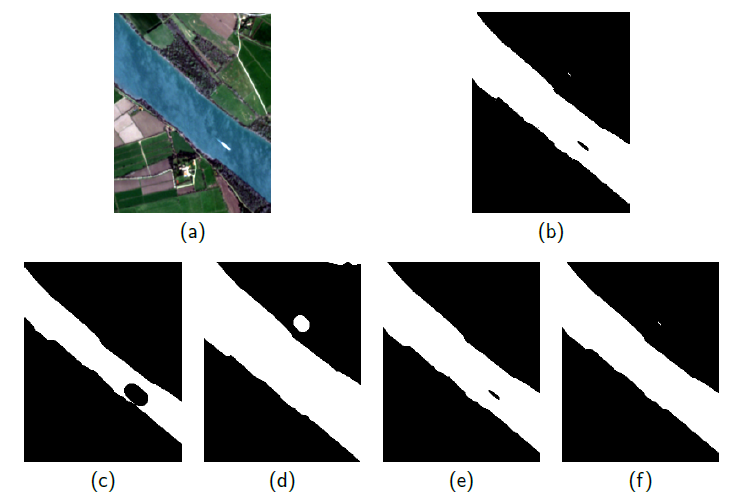

**Use the `apply_morphological_filter` function to post-process your prediction map**. You can then visualize it in python and QGIS (export in raster before).

In [ ]:
def apply_morphological_filter(image, operation='opening', kernel_size=3, shape='disk'):
    """
    Apply morphological opening or closing using skimage.morphology.

    Parameters:
        image (ndarray): Input binary or grayscale image.
        operation (str): 'opening' or 'closing'.
        kernel_size (int): Size of the structuring element.
        shape (str): Shape of the structuring element: 'disk', 'square', or 'rectangle'.

    Returns:
        filtered_image (ndarray): Image after morphological operation.
    """

    # Choose the structuring element based on the shape
    if shape == 'disk':
        # Create a disk-shaped structuring element
        selem = disk(kernel_size)
    elif shape == 'square':
        # Create a square-shaped structuring element
        selem = square(kernel_size)
    elif shape == 'rectangle':
        # Create a rectangular structuring element (height = width = kernel_size)
        selem = rectangle(kernel_size, kernel_size)
    else:
        raise ValueError("Shape must be 'disk', 'square', or 'rectangle'.")

    # Apply the chosen morphological operation
    if operation == 'opening':
        # Opening removes small objects/noise
        filtered_image = opening(image, selem)
    elif operation == 'closing':
        # Closing fills small holes/gaps
        filtered_image = closing(image, selem)
    else:
        raise ValueError("Operation must be 'opening' or 'closing'.")

    # Return the filtered image
    return filtered_image

# Deliverables

Prepare a presentation explaining your methodological choices, including  model(s) tested, data used, and strategies implemented to improve performance.

Include a qualitative analysis of the prediction map. Do the predictions seem reliable? Are there any areas where errors occur? Are there flooded areas that remain undetected?

You can visualize the data into QGIS, a file with the style (`.qml` is available in the folder `Additional_files`) will allow you to show flooded areas in blue (call me or ask others if you don't know how to do this in QGis).

# Bonus
If you have time, you can use your prediction map to make analyses, you can choose one of the following examples:

* use your prediction map with the UNOSAT cartography (`PL_20240501_FloodExtent_Nairobi_Kiambu.shp`) from May 1st. Try to estimate the surface area of new flooded areas between the two images (or the surface area of areas over which water has receded). Feasible on QGIS or in Python.
* use the national building file (https://data.humdata.org/dataset/hotosm_ken_buildings/resource/9b48a5d4-cfaf-49c0-9f84-4e3f7c0f8ce4) to estimate the number of buildings affected by flooding. Can be done in QGIS.
* Select new areas in the satellite image on which to apply the model --> For example, at Maiai Mahui, there was a mudslide, it's not a flood but it looks like one, will the model work on this area? You need to take a new satellite image and redo part of the pre-process, the data is available in the `Additional_files` folder.
* You can try modifying the training and test zones to create a new data set and try to improve performance.


 Come and ask me for help with these tasks, especially if you don't know QGIS.